# SPM12 scripting in a Jupyter notebook with an Octave kernel 

In [12]:
%-Welcome
spm('asciiwelcome');
[vspm,rspm] = spm('Ver');
tlkt = ver(spm_check_version);
fprintf('%s, version %s\n',vspm,rspm);
fprintf('%s, version %s\n',tlkt.Name,version);

 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM12 - https://www.fil.ion.ucl.ac.uk/spm/

SPM12, version 7771
Octave, version 4.2.2


In [11]:
% Initialize directory structure for data inputs and outputs
% Preprocessed and analysed data will be in "results/" folder
data_dir = fullfile(getenv('HOME'),'ds000157-download');
spm_dir = fullfile(getenv('HOME'),'spm12');
results_dir = fullfile(getenv('HOME'),'results');
stats_dir = [results_dir filesep 'stats'];
processing_dir = [results_dir filesep 'preproc_data'];
if ~exist(stats_dir,'dir')
    mkdir(stats_dir)
end
if ~exist(processing_dir,'dir')
    mkdir(processing_dir)
end
% Initialize subject data; extract; copy to preprocessing folder
sub = '01';
s_raw_fn = fullfile(data_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii.gz']);
if exist(s_raw_fn, 'file')
    out_fns = gunzip(s_raw_fn);
    s_fn = out_fns{1};
else
    s_fn = strrep(s_raw_fn, '.gz', '');
end
f_raw_fn = fullfile(data_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii.gz']);
if exist(f_raw_fn, 'file')
    out_fns = gunzip(f_raw_fn);
    f_fn = out_fns{1};
else
    f_fn = strrep(f_raw_fn, '.gz', '');
end
% Create preprocessing subfolders
anat_dir = fullfile(processing_dir, ['sub-' sub], 'anat'); 
func_dir = fullfile(processing_dir, ['sub-' sub], 'func'); 
if ~exist(anat_dir, 'dir')
    mkdir(anat_dir)
end
if ~exist(func_dir, 'dir')
    mkdir(func_dir)
end
% Copy extracted files to preprocessing subfolders
anat_fn = fullfile(processing_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii']);
func_fn = fullfile(processing_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii']);
if ~exist(anat_fn, 'file')
    copyfile(s_fn, anat_dir)
end
if ~exist(func_fn, 'file')
    copyfile(f_fn, func_dir)
end
% Initialize processing variables
fwhm = 6;  % mm

/home/jovyan/results/preproc_data/sub-01/anat
/home/jovyan/results/preproc_data/sub-01/func
ans = 1
ans = 1


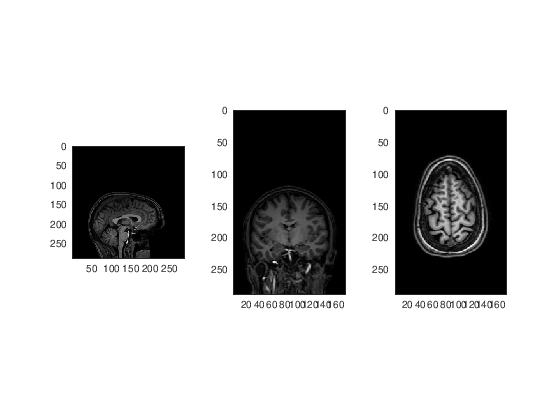

In [17]:
%% QUICK INSPECTION OF ANATOMICAL DATA
[p_anat, frm1, rg1, dim1] = fmrwhy_util_readNifti(anat_fn);
anat_3Dimg = p_anat.nii.img;

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(131); imagesc(rot90(squeeze(anat_3Dimg(round(Ni/2),:,:)))); colormap gray; axis image
subplot(132); imagesc(rot90(squeeze(anat_3Dimg(:,round(Nj/2),:)))); colormap gray; axis image
subplot(133); imagesc(rot90(squeeze(anat_3Dimg(:,:,round(Nk/2))))); colormap gray; axis image

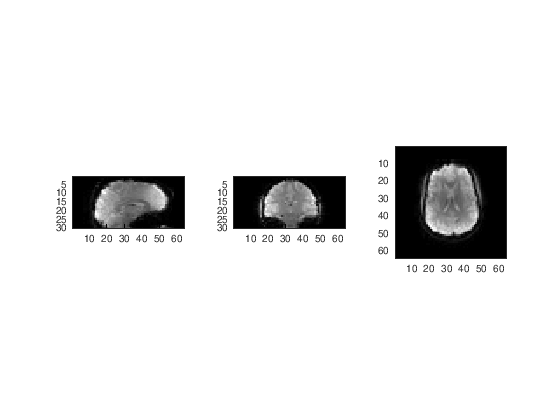

In [18]:
%% QUICK INSPECTION OF FUNCTIONAL DATA

[p_func, frm1, rg1, dim1] = fmrwhy_util_readNifti(func_fn);
func_4Dimg = p_func.nii.img;

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(131); imagesc(rot90(squeeze(func_4Dimg(round(Ni/2),:,:,1)))); colormap gray; axis image
subplot(132); imagesc(rot90(squeeze(func_4Dimg(:,round(Nj/2),:,1)))); colormap gray; axis image
subplot(133); imagesc(rot90(squeeze(func_4Dimg(:,:,round(Nk/2),1)))); colormap gray; axis image

In [19]:
%% PREPROCESSING
% Preprocess structural and functional images (if not already)
[d, f, e] = fileparts(anat_fn);
[d1, f1, e1] = fileparts(func_fn);
if exist([d filesep 'rc1' f e], 'file')
    disp('...preproc already done, saving variables...')
    preproc_data = struct;
    % Structural filenames
    preproc_data.forward_transformation = [d filesep 'y_' f e];
    preproc_data.inverse_transformation = [d filesep 'iy_' f e];
    preproc_data.gm_fn = [d filesep 'c1' f e];
    preproc_data.wm_fn = [d filesep 'c2' f e];
    preproc_data.csf_fn = [d filesep 'c3' f e];
    preproc_data.bone_fn = [d filesep 'c4' f e];
    preproc_data.soft_fn = [d filesep 'c5' f e];
    preproc_data.air_fn = [d filesep 'c6' f e];
    preproc_data.rstructural_fn = [d filesep 'r' f e];
    preproc_data.rgm_fn = [d filesep 'rc1' f e];
    preproc_data.rwm_fn = [d filesep 'rc2' f e];
    preproc_data.rcsf_fn = [d filesep 'rc3' f e];
    preproc_data.rbone_fn = [d filesep 'rc4' f e];
    preproc_data.rsoft_fn = [d filesep 'rc5' f e];
    preproc_data.rair_fn = [d filesep 'rc6' f e];
    % Functional filenames
    preproc_data.rfunctional_fn = [d1 filesep 'r' f1 e1];
    preproc_data.srfunctional_fn = [d1 filesep 'sr' f1 e1];
    preproc_data.mp_fn = [d1 filesep 'rp_' f1 '.txt'];
    preproc_data.MP = load(preproc_data.mp_fn);
else
    disp('...running preprocessing batch jobs...')
    preproc_data = spm_standardPreproc_jsh(func_fn, anat_fn, fwhm, spm_dir);
end

...running preprocessing batch jobs...
Step 1 -- Realign all volumes to first functional volume


------------------------------------------------------------------------
11-Apr-2020 12:28:16 - Running job #1
------------------------------------------------------------------------
11-Apr-2020 12:28:16 - Running 'Realign: Estimate & Reslice'

SPM12: spm_realign (v7141)                         12:28:16 - 11/04/2020
Completed                               :          12:29:34 - 11/04/2020

SPM12: spm_reslice (v7141)                         12:29:34 - 11/04/2020
11-Apr-2020 12:29:42 - Failed  'Realign: Estimate & Reslice'
mat2file.c not compiled - see Makefile
In file "/home/jovyan/spm12/@file_array/private/mat2file.m" (v7147), function "mat2file" at line 16.
In file "/home/jovyan/spm12/@file_array/subsasgn.m" (v7147), function "subsasgn>subfun" at line 164.
In file "/home/jovyan/spm12/@file_array/subsasgn.m" (v7147), function "subsasgn" at line 85.
In file "/home/jovyan/spm12/spm_write_pla